# 🌤️ Blinkit 수요 예측 - 기상요인 포함 모델링

## 목차
1. 라이브러리 및 데이터 로드
2. 기상 데이터 탐색적 분석 (EDA)
3. 기상요인 상관관계 분석
4. 기상 피처 엔지니어링
5. 기상 포함 수요 예측 모델링
6. 기상 미포함 vs 포함 모델 비교
7. 결과 저장 및 시각화


## 1. 라이브러리 및 데이터 로드


In [26]:
# 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료!")


✅ 라이브러리 로드 완료!


In [27]:
# 기상 데이터 로드
df_weather_daily = pd.read_csv(r'C:\Users\kchne\Downloads\blinkit_with_weather.csv')
df_weather_weekly = pd.read_csv(r'C:\Users\kchne\Downloads\blinkit_weekly_product_weather.csv')

print("=" * 60)
print("📁 일별 기상 데이터 (blinkit_with_weather.csv)")
print("=" * 60)
print(f"Shape: {df_weather_daily.shape}")
print(f"\n컬럼 목록:")
print(df_weather_daily.columns.tolist())

print("\n" + "=" * 60)
print("📁 주별 기상 데이터 (blinkit_weekly_product_weather.csv)")
print("=" * 60)
print(f"Shape: {df_weather_weekly.shape}")
print(f"\n컬럼 목록:")
print(df_weather_weekly.columns.tolist())


📁 일별 기상 데이터 (blinkit_with_weather.csv)
Shape: (5000, 20)

컬럼 목록:
['주문날짜', '상품_ID', '상품명', '카테고리', '브랜드', '유통기한_일수', '지역', '회원타입', '금액', '배송_지연시간', '배송소요시간', '수량', '평점', '상품별_평균평점', 'temp_max(최고 기온)', 'temp_min(최저 기온)', 'rain_pre(강수량 합계)', 'temp_range(최고 기온-최저 기온)', 'heatwave(폭염)', 'heavy_rain(폭우)']

📁 주별 기상 데이터 (blinkit_weekly_product_weather.csv)
Shape: (4984, 10)

컬럼 목록:
['주간_시작일', '지역', '상품명', '주간_상품_판매량', '주간_평균_최고기온', '주간_평균_최저기온', '주간_평균_일교차', '주간_평균_강수량', '주간_폭염_일수', '주간_폭우_일수']


In [28]:
# 데이터 미리보기
print("📊 일별 기상 데이터 샘플:")
display(df_weather_daily.head())

print("\n📊 주별 기상 데이터 샘플:")
display(df_weather_weekly.head())


📊 일별 기상 데이터 샘플:


,주문날짜,상품_ID,상품명,카테고리,브랜드,유통기한_일수,지역,회원타입,금액,배송_지연시간,배송소요시간,수량,평점,상품별_평균평점,temp_max(최고 기온),temp_min(최저 기온),rain_pre(강수량 합계),temp_range(최고 기온-최저 기온),heatwave(폭염),heavy_rain(폭우)
0,2024-07-17,642612,Pet Treats,Pet Care,Pillay-Ahuja,365,Allahabad,Regular,1551.09,-5.0,13.0,3,4,3.62,32.5,28.0,2.5,4.5,0.0,0.0
1,2024-05-28,378676,Orange Juice,Cold Drinks & Juices,Baral-Kamdar,180,Thrissur,New,881.42,2.0,13.0,1,3,3.29,26.6,25.0,171.9,1.6,0.0,1.0
2,2024-09-23,741341,Eggs,Dairy & Breakfast,Prasad LLC,7,Vellore,Inactive,1847.68,4.0,22.0,2,3,3.40,33.0,24.8,15.5,8.2,0.0,0.0
3,2023-11-24,561860,Orange Juice,Cold Drinks & Juices,Gupta Ltd,180,Gaya,Premium,874.78,-1.0,17.0,1,4,3.22,26.0,15.8,0.0,10.2,0.0,0.0
4,2023-11-20,602241,Nuts,Snacks & Munchies,Bahl-Pau,90,Asansol,Premium,1953.10,1.0,18.0,2,3,3.16,29.5,18.8,0.0,10.7,0.0,0.0



📊 주별 기상 데이터 샘플:


,주간_시작일,지역,상품명,주간_상품_판매량,주간_평균_최고기온,주간_평균_최저기온,주간_평균_일교차,주간_평균_강수량,주간_폭염_일수,주간_폭우_일수
0,2023-03-14,Aurangabad,Baby Food,3,29.8,22.7,7.1,0.0,0.0,0.0
1,2023-03-14,Avadi,Pain Reliever,1,30.3,24.6,5.7,5.9,0.0,0.0
2,2023-03-14,Barasat,Baby Wipes,2,33.2,21.9,11.3,12.5,0.0,0.0
3,2023-03-14,Bhagalpur,Orange Juice,3,29.2,19.2,10.0,1.1,0.0,0.0
4,2023-03-14,Bihar Sharif,Spinach,3,32.8,19.8,13.0,0.0,0.0,0.0


## 2. 기상 데이터 탐색적 분석 (EDA)


In [29]:
# 일별 데이터의 기상 컬럼 통계
weather_cols_daily = ['temp_max(최고 기온)', 'temp_min(최저 기온)', 'rain_pre(강수량 합계)', 
                      'temp_range(최고 기온-최저 기온)', 'heatwave(폭염)', 'heavy_rain(폭우)']

print("📊 일별 기상 데이터 기술통계:")
display(df_weather_daily[weather_cols_daily].describe())


📊 일별 기상 데이터 기술통계:


,temp_max(최고 기온),temp_min(최저 기온),rain_pre(강수량 합계),temp_range(최고 기온-최저 기온),heatwave(폭염),heavy_rain(폭우)
count,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000
mean,31.658738,22.332997,4.729248,9.325741,0.101189,0.010683
std,4.816361,4.921792,10.871878,3.506096,0.301610,0.102817
min,14.500000,4.600000,0.000000,1.000000,0.000000,0.000000
25%,29.000000,20.000000,0.000000,6.600000,0.000000,0.000000
50%,31.500000,23.600000,0.100000,9.200000,0.000000,0.000000
75%,34.200000,25.700000,4.100000,12.100000,0.000000,0.000000
max,46.500000,33.700000,171.900000,19.700000,1.000000,1.000000


In [30]:
# 주별 데이터의 기상 컬럼 통계
weather_cols_weekly = ['주간_평균_최고기온', '주간_평균_최저기온', '주간_평균_일교차', 
                       '주간_평균_강수량', '주간_폭염_일수', '주간_폭우_일수']

print("📊 주별 기상 데이터 기술통계:")
display(df_weather_weekly[weather_cols_weekly].describe())


📊 주별 기상 데이터 기술통계:


,주간_평균_최고기온,주간_평균_최저기온,주간_평균_일교차,주간_평균_강수량,주간_폭염_일수,주간_폭우_일수
count,4945.000000,4945.000000,4945.000000,4945.000000,4984.000000,4984.000000
mean,31.655561,22.332599,9.322963,4.740718,0.100722,0.010634
std,4.817934,4.922436,3.507345,10.886663,0.300991,0.102582
min,14.500000,4.600000,1.000000,0.000000,0.000000,0.000000
25%,29.000000,20.000000,6.600000,0.000000,0.000000,0.000000
50%,31.500000,23.600000,9.200000,0.100000,0.000000,0.000000
75%,34.200000,25.700000,12.100000,4.100000,0.000000,0.000000
max,46.500000,33.700000,19.700000,171.900000,1.000000,1.000000


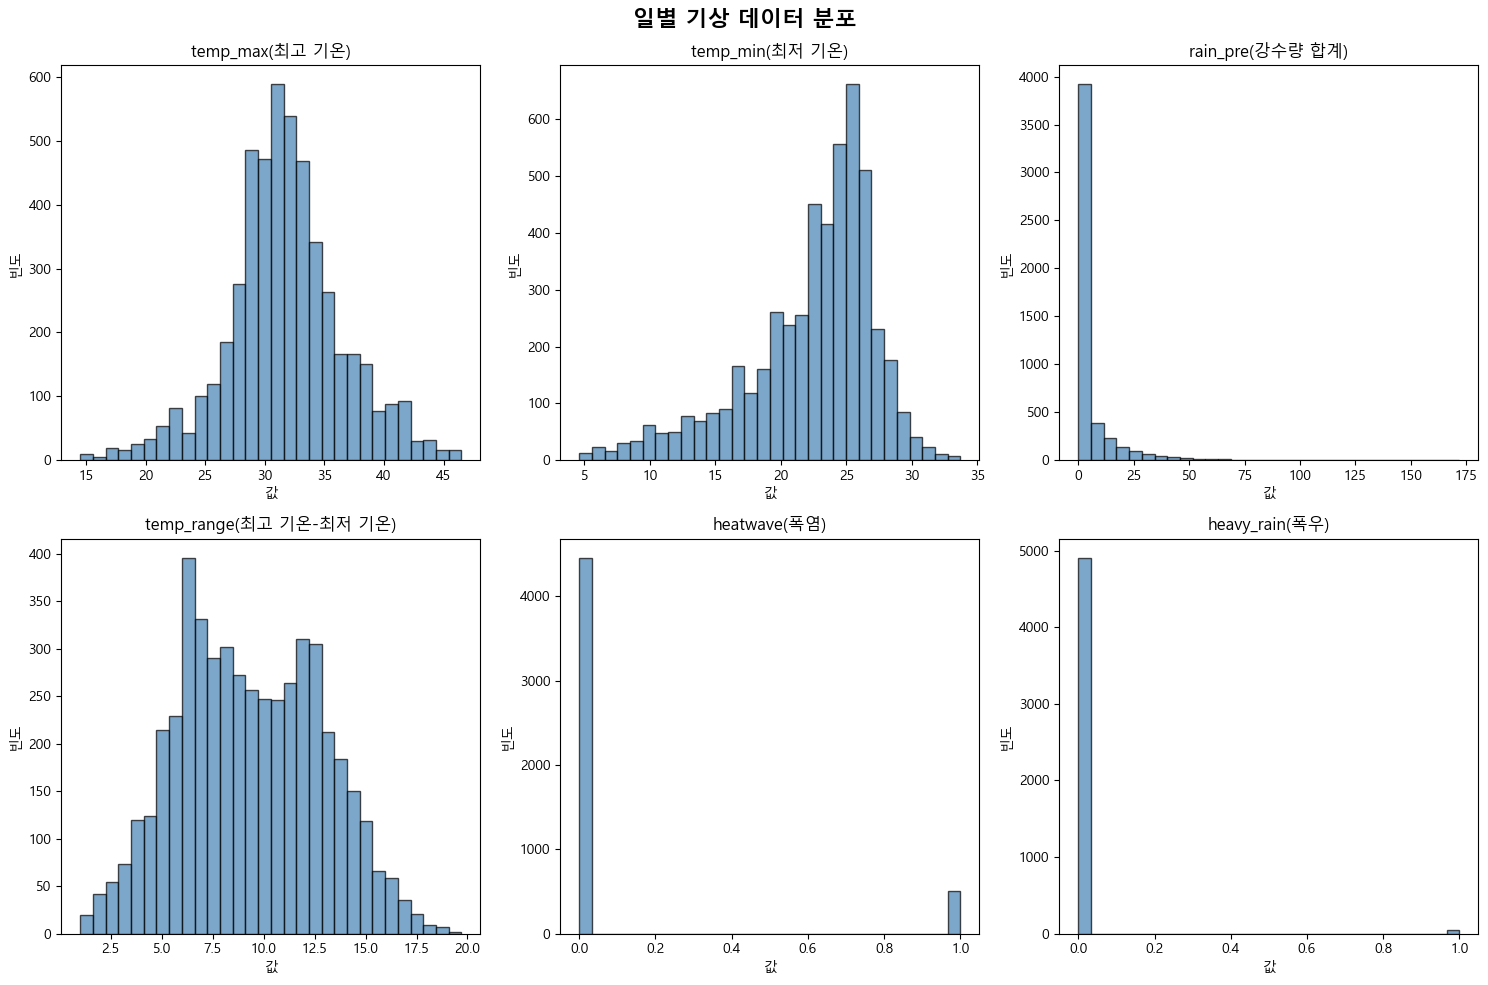

In [31]:
# 기상 분포 시각화 (일별)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('일별 기상 데이터 분포', fontsize=16, fontweight='bold')

for idx, col in enumerate(weather_cols_daily):
    row, col_idx = idx // 3, idx % 3
    axes[row, col_idx].hist(df_weather_daily[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel('값')
    axes[row, col_idx].set_ylabel('빈도')

plt.tight_layout()
plt.show()


📊 카테고리별 판매량:


카테고리
Dairy & Breakfast        1114
Household Care           1078
Pet Care                 1003
Pharmacy                  973
Fruits & Vegetables       966
Snacks & Munchies         963
Grocery & Staples         895
Personal Care             887
Cold Drinks & Juices      758
Instant & Frozen Food     742
Baby Care                 655
Name: 수량, dtype: int64

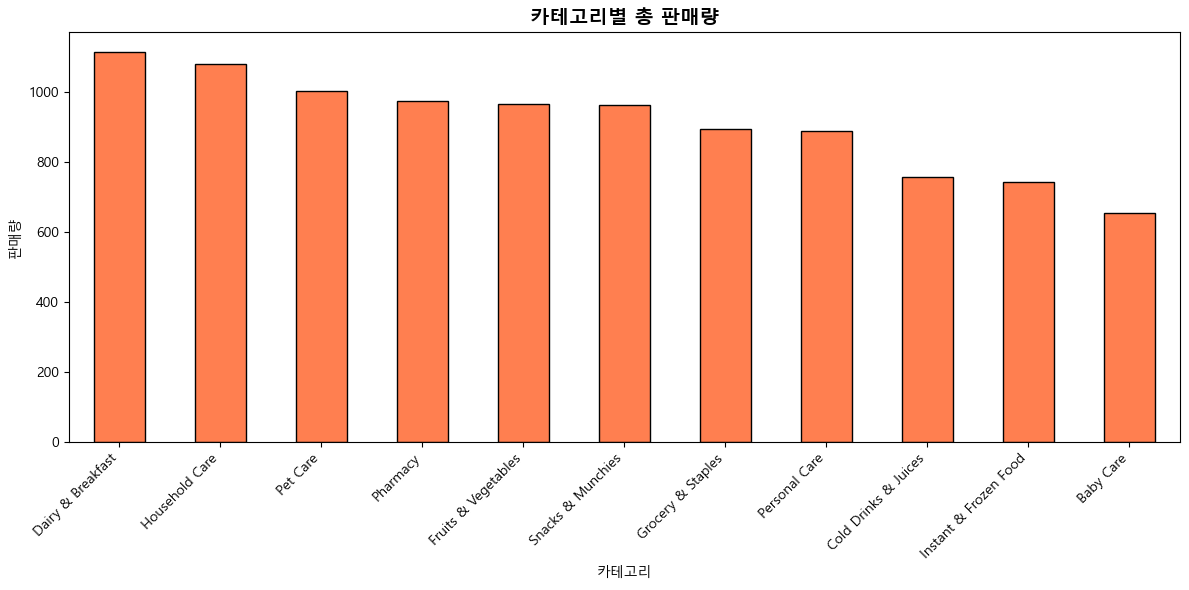

In [32]:
# 카테고리별 판매량 분포
print("📊 카테고리별 판매량:")
category_sales = df_weather_daily.groupby('카테고리')['수량'].sum().sort_values(ascending=False)
display(category_sales)

plt.figure(figsize=(12, 6))
category_sales.plot(kind='bar', color='coral', edgecolor='black')
plt.title('카테고리별 총 판매량', fontsize=14, fontweight='bold')
plt.xlabel('카테고리')
plt.ylabel('판매량')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 3. 기상요인 상관관계 분석


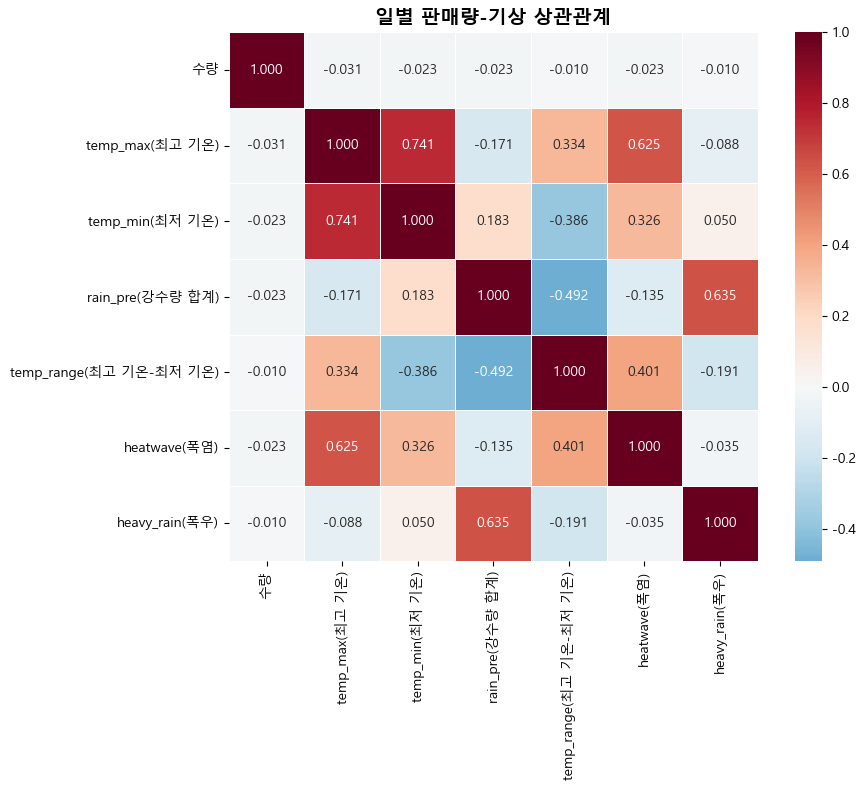


📌 수량과의 상관계수:
수량                         1.000000
temp_range(최고 기온-최저 기온)   -0.010085
heavy_rain(폭우)            -0.010352
rain_pre(강수량 합계)          -0.022711
heatwave(폭염)              -0.022924
temp_min(최저 기온)           -0.023063
temp_max(최고 기온)           -0.030909
Name: 수량, dtype: float64


In [33]:
# 수량과 기상 변수 간 상관관계 (일별)
corr_cols_daily = ['수량', 'temp_max(최고 기온)', 'temp_min(최저 기온)', 
                   'rain_pre(강수량 합계)', 'temp_range(최고 기온-최저 기온)', 
                   'heatwave(폭염)', 'heavy_rain(폭우)']

corr_matrix_daily = df_weather_daily[corr_cols_daily].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_daily, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            linewidths=0.5, square=True)
plt.title('일별 판매량-기상 상관관계', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📌 수량과의 상관계수:")
print(corr_matrix_daily['수량'].sort_values(ascending=False))


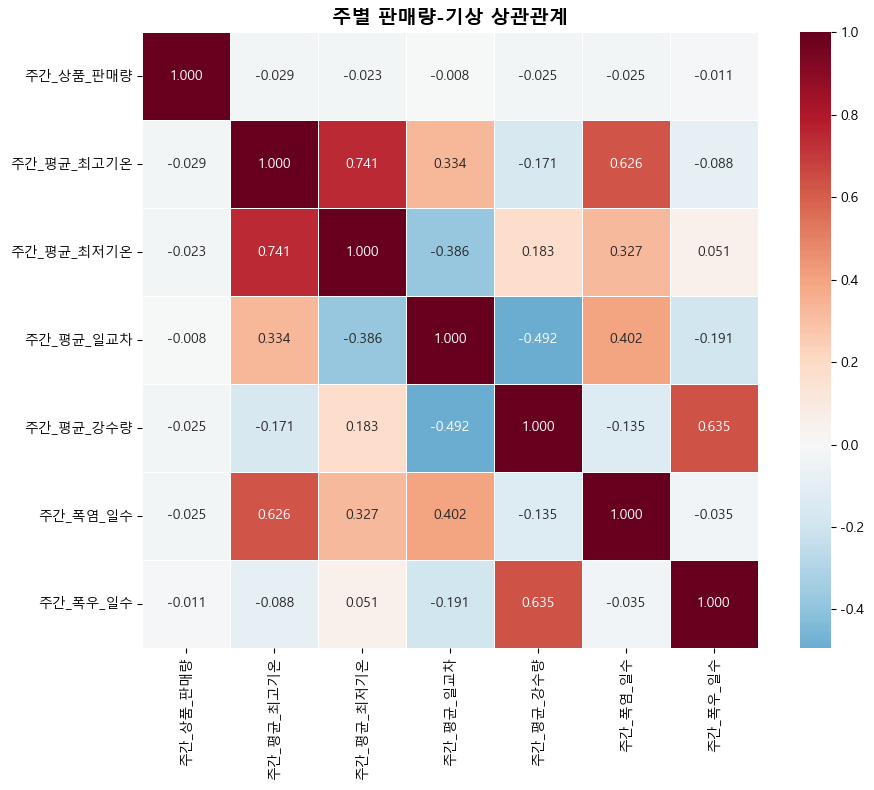


📌 주간 판매량과의 상관계수:
주간_상품_판매량     1.000000
주간_평균_일교차    -0.007778
주간_폭우_일수     -0.011101
주간_평균_최저기온   -0.022721
주간_폭염_일수     -0.024661
주간_평균_강수량    -0.025149
주간_평균_최고기온   -0.028876
Name: 주간_상품_판매량, dtype: float64


In [34]:
# 주별 판매량과 기상 상관관계
corr_cols_weekly = ['주간_상품_판매량', '주간_평균_최고기온', '주간_평균_최저기온', 
                    '주간_평균_일교차', '주간_평균_강수량', '주간_폭염_일수', '주간_폭우_일수']

corr_matrix_weekly = df_weather_weekly[corr_cols_weekly].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_weekly, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            linewidths=0.5, square=True)
plt.title('주별 판매량-기상 상관관계', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📌 주간 판매량과의 상관계수:")
print(corr_matrix_weekly['주간_상품_판매량'].sort_values(ascending=False))


📊 카테고리별 기상 민감도 분석


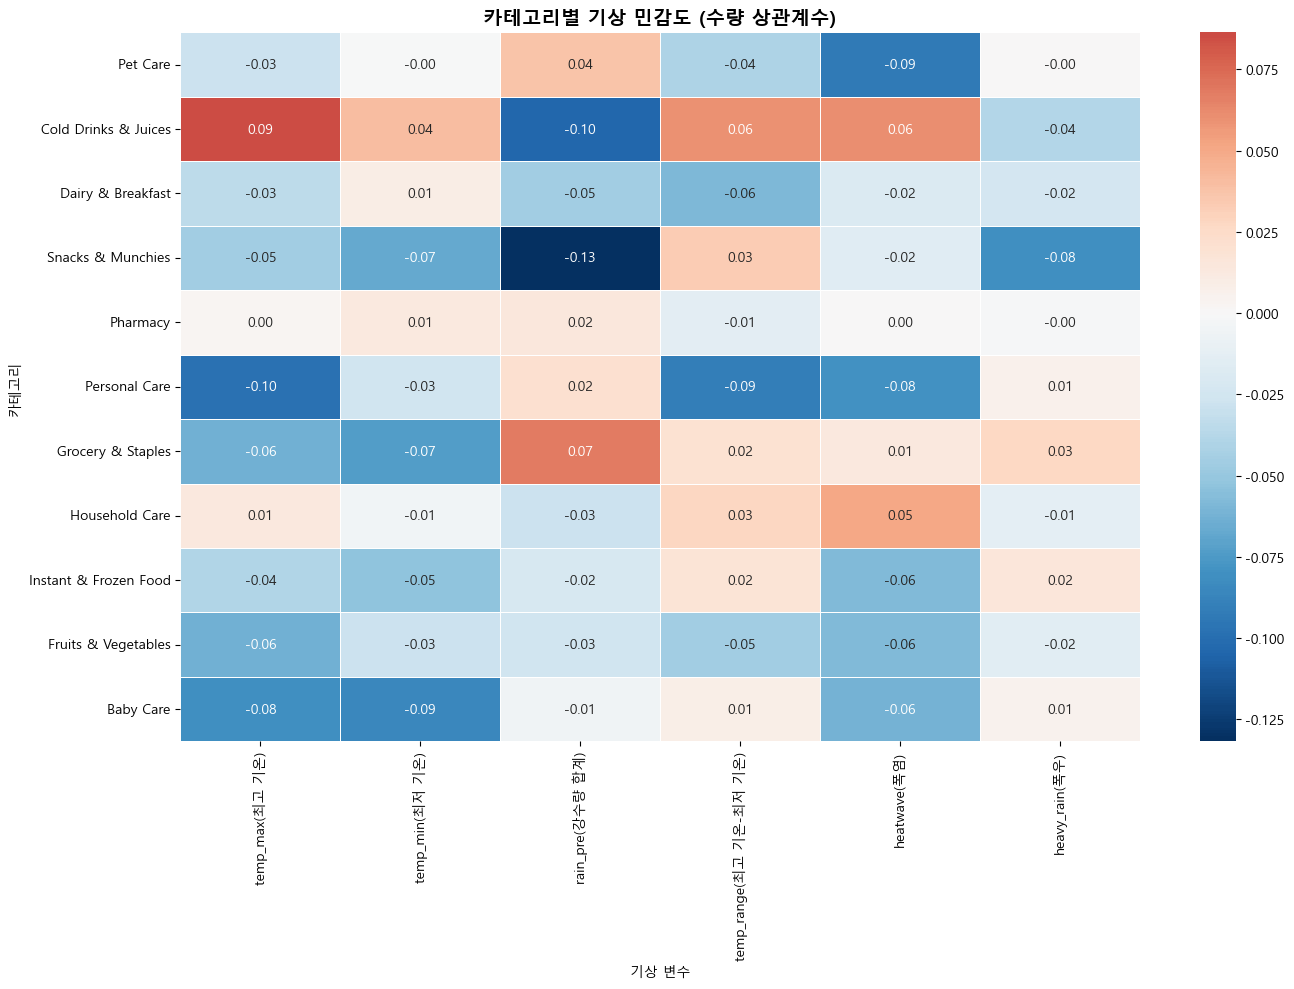

,temp_max(최고 기온),temp_min(최저 기온),rain_pre(강수량 합계),temp_range(최고 기온-최저 기온),heatwave(폭염),heavy_rain(폭우)
카테고리,,,,,,
Pet Care,-0.027835,-0.000606,0.037318,-0.040357,-0.093333,-0.000302
Cold Drinks & Juices,0.086434,0.040862,-0.104369,0.059925,0.061690,-0.038713
Dairy & Breakfast,-0.034366,0.009749,-0.046306,-0.058790,-0.018702,-0.024285
Snacks & Munchies,-0.045756,-0.067211,-0.131765,0.032888,-0.016015,-0.080378
Pharmacy,0.002054,0.012368,0.015093,-0.013780,0.000469,-0.001888
Personal Care,-0.098028,-0.026489,0.020863,-0.091546,-0.079123,0.006330
Grocery & Staples,-0.062993,-0.073164,0.068226,0.020618,0.013622,0.027375
Household Care,0.013672,-0.005047,-0.027785,0.028274,0.051199,-0.013143
Instant & Frozen Food,-0.039657,-0.052968,-0.021963,0.017512,-0.057812,0.016164


In [35]:
# 카테고리별 기상 민감도 분석 (일별)
print("📊 카테고리별 기상 민감도 분석")
print("=" * 60)

category_weather_corr = []

for category in df_weather_daily['카테고리'].unique():
    cat_df = df_weather_daily[df_weather_daily['카테고리'] == category]
    if len(cat_df) >= 30:  # 최소 30개 데이터
        corr = cat_df[corr_cols_daily].corr()['수량'].drop('수량')
        corr['카테고리'] = category
        category_weather_corr.append(corr)

df_cat_weather_corr = pd.DataFrame(category_weather_corr)
df_cat_weather_corr = df_cat_weather_corr.set_index('카테고리')

# 히트맵 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(df_cat_weather_corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            linewidths=0.5)
plt.title('카테고리별 기상 민감도 (수량 상관계수)', fontsize=14, fontweight='bold')
plt.xlabel('기상 변수')
plt.ylabel('카테고리')
plt.tight_layout()
plt.show()

display(df_cat_weather_corr)


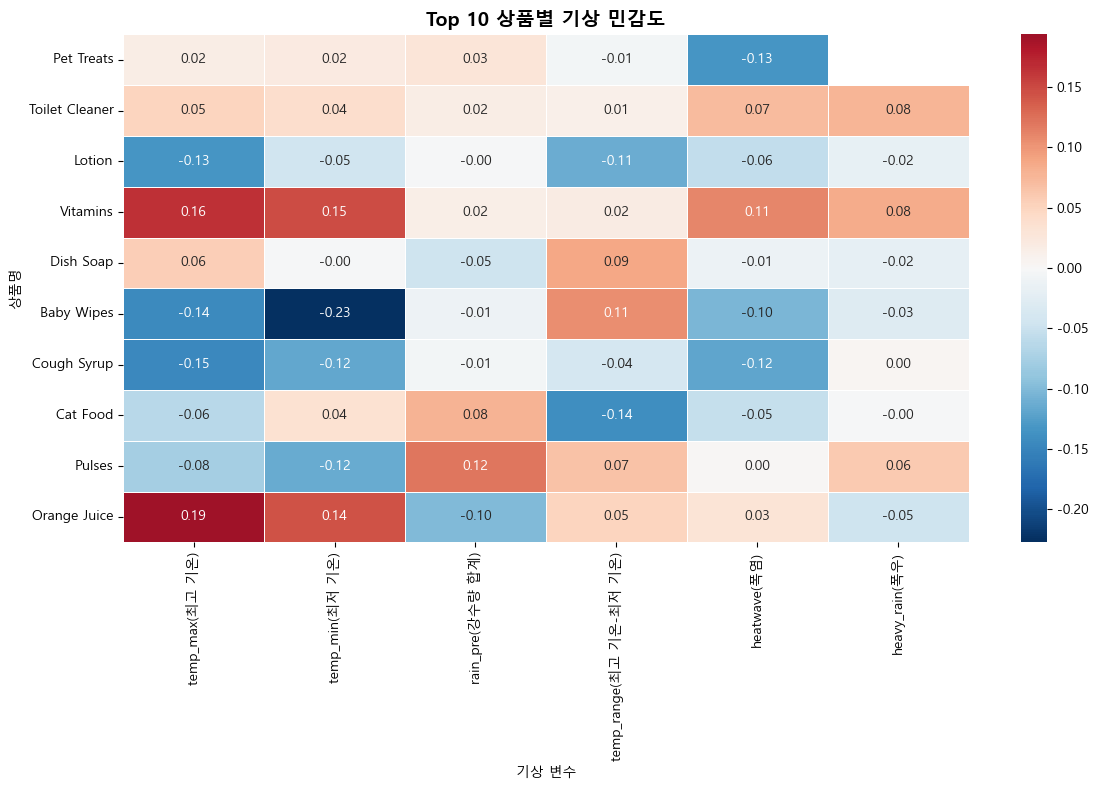


✅ top10_product_weather_correlation.csv 저장 완료!


In [36]:
# Top 10 상품별 기상 민감도 분석
top_10_products = ['Pet Treats', 'Toilet Cleaner', 'Lotion', 'Vitamins', 'Dish Soap',
                   'Baby Wipes', 'Cough Syrup', 'Cat Food', 'Pulses', 'Orange Juice']

product_weather_corr = []

for product in top_10_products:
    prod_df = df_weather_daily[df_weather_daily['상품명'] == product]
    if len(prod_df) >= 20:
        corr = prod_df[corr_cols_daily].corr()['수량'].drop('수량')
        corr['상품명'] = product
        product_weather_corr.append(corr)

df_prod_weather_corr = pd.DataFrame(product_weather_corr)
df_prod_weather_corr = df_prod_weather_corr.set_index('상품명')

# 히트맵
plt.figure(figsize=(12, 8))
sns.heatmap(df_prod_weather_corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            linewidths=0.5)
plt.title('Top 10 상품별 기상 민감도', fontsize=14, fontweight='bold')
plt.xlabel('기상 변수')
plt.ylabel('상품명')
plt.tight_layout()
plt.show()

# 저장
df_prod_weather_corr.to_csv('top10_product_weather_correlation.csv', encoding='utf-8-sig')
print("\n✅ top10_product_weather_correlation.csv 저장 완료!")


📊 지역별 기상 영향 분석
총 316개 지역


,총_판매량,평균_최고기온,평균_최저기온,평균_강수량,폭염_횟수,폭우_횟수
지역,,,,,,
Orai,93,32.75,22.62,3.03,10.0,0.0
Deoghar,79,28.79,18.91,4.82,1.0,0.0
Nandyal,73,32.09,22.19,6.55,1.0,1.0
Bathinda,73,30.52,20.35,4.25,2.0,1.0
Gandhinagar,71,35.26,25.04,5.29,14.0,1.0
Ratlam,70,32.06,22.12,4.45,6.0,0.0
Ghaziabad,70,28.92,18.70,3.90,2.0,0.0
Tezpur,67,29.29,19.79,6.51,0.0,0.0
Burhanpur,65,30.58,20.27,1.16,5.0,0.0


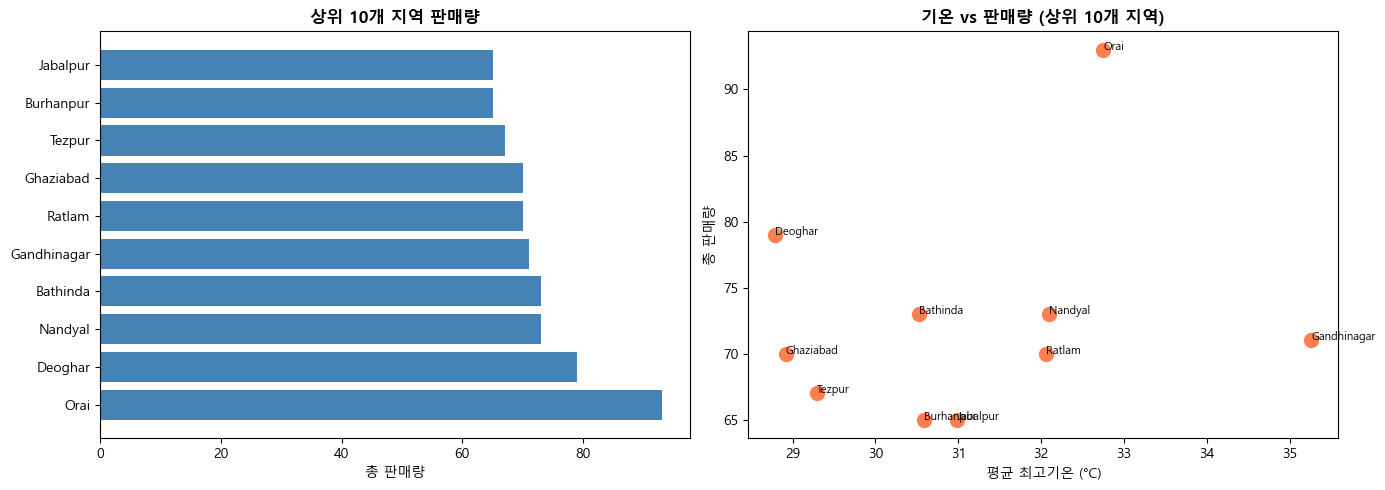

In [37]:
# 지역별 기상 영향 분석
print("📊 지역별 기상 영향 분석")
print("=" * 60)

# 지역별 기상 데이터 요약
region_weather = df_weather_daily.groupby('지역').agg({
    '수량': 'sum',
    'temp_max(최고 기온)': 'mean',
    'temp_min(최저 기온)': 'mean',
    'rain_pre(강수량 합계)': 'mean',
    'heatwave(폭염)': 'sum',
    'heavy_rain(폭우)': 'sum'
}).round(2)

region_weather.columns = ['총_판매량', '평균_최고기온', '평균_최저기온', '평균_강수량', '폭염_횟수', '폭우_횟수']
region_weather = region_weather.sort_values('총_판매량', ascending=False)

print(f"총 {len(region_weather)}개 지역")
display(region_weather.head(20))

# 상위 10개 지역 시각화
top_regions = region_weather.head(10)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(top_regions.index, top_regions['총_판매량'], color='steelblue')
axes[0].set_xlabel('총 판매량')
axes[0].set_title('상위 10개 지역 판매량', fontweight='bold')

axes[1].scatter(top_regions['평균_최고기온'], top_regions['총_판매량'], s=100, c='coral')
for i, region in enumerate(top_regions.index):
    axes[1].annotate(region, (top_regions.loc[region, '평균_최고기온'], top_regions.loc[region, '총_판매량']), fontsize=8)
axes[1].set_xlabel('평균 최고기온 (°C)')
axes[1].set_ylabel('총 판매량')
axes[1].set_title('기온 vs 판매량 (상위 10개 지역)', fontweight='bold')

plt.tight_layout()
plt.show()


## 4. 기상 피처 엔지니어링


In [38]:
# 일별 데이터 전처리
df = df_weather_daily.copy()

# 날짜 변환
df['주문날짜'] = pd.to_datetime(df['주문날짜'])

# 컬럼명 간소화
df = df.rename(columns={
    'temp_max(최고 기온)': 'temp_max',
    'temp_min(최저 기온)': 'temp_min',
    'rain_pre(강수량 합계)': 'rainfall',
    'temp_range(최고 기온-최저 기온)': 'temp_range',
    'heatwave(폭염)': 'heatwave',
    'heavy_rain(폭우)': 'heavy_rain'
})

print(f"데이터 Shape: {df.shape}")
display(df.head())


데이터 Shape: (5000, 20)


,주문날짜,상품_ID,상품명,카테고리,브랜드,유통기한_일수,지역,회원타입,금액,배송_지연시간,배송소요시간,수량,평점,상품별_평균평점,temp_max,temp_min,rainfall,temp_range,heatwave,heavy_rain
0,2024-07-17,642612,Pet Treats,Pet Care,Pillay-Ahuja,365,Allahabad,Regular,1551.09,-5.0,13.0,3,4,3.62,32.5,28.0,2.5,4.5,0.0,0.0
1,2024-05-28,378676,Orange Juice,Cold Drinks & Juices,Baral-Kamdar,180,Thrissur,New,881.42,2.0,13.0,1,3,3.29,26.6,25.0,171.9,1.6,0.0,1.0
2,2024-09-23,741341,Eggs,Dairy & Breakfast,Prasad LLC,7,Vellore,Inactive,1847.68,4.0,22.0,2,3,3.40,33.0,24.8,15.5,8.2,0.0,0.0
3,2023-11-24,561860,Orange Juice,Cold Drinks & Juices,Gupta Ltd,180,Gaya,Premium,874.78,-1.0,17.0,1,4,3.22,26.0,15.8,0.0,10.2,0.0,0.0
4,2023-11-20,602241,Nuts,Snacks & Munchies,Bahl-Pau,90,Asansol,Premium,1953.10,1.0,18.0,2,3,3.16,29.5,18.8,0.0,10.7,0.0,0.0


In [39]:
# ⚠️ 중요: 지역별로 기상 데이터가 다르므로 지역을 포함하여 집계!
# 방법 1: 지역 포함 집계 (더 정확한 분석)
df_daily_region = df.groupby(['주문날짜', '상품명', '지역']).agg({
    '수량': 'sum',
    '금액': 'sum',
    '평점': 'mean',
    '배송소요시간': 'mean',
    'temp_max': 'mean',  # 같은 지역이면 같은 값
    'temp_min': 'mean',
    'rainfall': 'mean',
    'temp_range': 'mean',
    'heatwave': 'max',
    'heavy_rain': 'max',
    '카테고리': 'first',
    '브랜드': 'first'
}).reset_index().sort_values(['상품명', '지역', '주문날짜'])

print(f"📊 지역 포함 집계 데이터: {df_daily_region.shape}")
print(f"   - 고유 지역 수: {df_daily_region['지역'].nunique()}개")
print(f"   - 고유 상품 수: {df_daily_region['상품명'].nunique()}개")
display(df_daily_region.head(10))

# 방법 2: 전체 평균 (비교용)
df_daily_avg = df.groupby(['주문날짜', '상품명']).agg({
    '수량': 'sum',
    '금액': 'sum',
    '평점': 'mean',
    '배송소요시간': 'mean',
    'temp_max': 'mean',  # 여러 지역의 평균
    'temp_min': 'mean',
    'rainfall': 'mean',
    'temp_range': 'mean',
    'heatwave': 'max',
    'heavy_rain': 'max',
    '카테고리': 'first',
    '브랜드': 'first'
}).reset_index().sort_values(['상품명', '주문날짜'])

print(f"\n📊 전체 평균 집계 데이터 (비교용): {df_daily_avg.shape}")

# 기본 분석에는 지역 포함 데이터 사용
df_daily = df_daily_region.copy()
print(f"\n✅ 분석에는 지역 포함 데이터를 사용합니다!")


📊 지역 포함 집계 데이터: (4996, 15)
   - 고유 지역 수: 316개
   - 고유 상품 수: 51개


,주문날짜,상품명,지역,수량,금액,평점,배송소요시간,temp_max,temp_min,rainfall,temp_range,heatwave,heavy_rain,카테고리,브랜드
380,2023-05-04,Baby Food,Agartala,3,2794.83,3.0,13.0,29.6,18.7,0.0,10.9,0.0,0.0,Baby Care,Karnik PLC
3192,2024-03-30,Baby Food,Agra,3,2744.64,4.0,39.0,37.8,22.3,0.3,15.5,0.0,0.0,Baby Care,Mallick PLC
3510,2024-05-07,Baby Food,Ahmedabad,1,914.88,3.0,24.0,43.0,27.6,0.0,15.4,1.0,0.0,Baby Care,Mallick PLC
2048,2023-11-17,Baby Food,Ajmer,3,568.41,3.0,8.0,25.6,13.9,0.0,11.7,0.0,0.0,Baby Care,"Garg, Saraf and Dutta"
1614,2023-09-27,Baby Food,Aligarh,2,473.02,4.0,21.0,33.0,24.9,0.0,8.1,0.0,0.0,Baby Care,Kashyap-Reddy
1837,2023-10-23,Baby Food,Ambala,1,931.61,2.0,9.0,28.6,15.9,0.0,12.7,0.0,0.0,Baby Care,Karnik PLC
1908,2023-11-01,Baby Food,Ambala,1,931.61,3.0,10.0,28.9,16.5,0.0,12.4,0.0,0.0,Baby Care,Karnik PLC
4066,2024-07-12,Baby Food,Anantapur,3,675.63,5.0,9.0,30.9,23.3,3.3,7.6,0.0,0.0,Baby Care,Sehgal-Nagarajan
22,2023-03-19,Baby Food,Aurangabad,3,2794.83,4.0,19.0,29.8,22.7,0.0,7.1,0.0,0.0,Baby Care,Karnik PLC
1008,2023-07-20,Baby Food,Bally,2,1829.76,4.0,24.0,32.8,26.8,1.6,6.0,0.0,0.0,Baby Care,Mallick PLC



📊 전체 평균 집계 데이터 (비교용): (4538, 14)

✅ 분석에는 지역 포함 데이터를 사용합니다!


In [40]:
# 시계열 피처 생성 (지역+상품명 기준으로 shift)
# 같은 지역, 같은 상품의 과거 데이터를 참조
df_daily['수량_lag_1'] = df_daily.groupby(['상품명', '지역'])['수량'].shift(1)
df_daily['수량_lag_7'] = df_daily.groupby(['상품명', '지역'])['수량'].shift(7)
df_daily['수량_MA3'] = df_daily.groupby(['상품명', '지역'])['수량'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
).shift(1)

# 변화량
df_daily['주문_증가량'] = df_daily['수량'] - df_daily['수량_lag_1']

# 날짜 피처
df_daily['month'] = df_daily['주문날짜'].dt.month
df_daily['day_of_week'] = df_daily['주문날짜'].dt.dayofweek
df_daily['is_weekend'] = df_daily['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 결측치 제거
df_model = df_daily.dropna()

print(f"✅ 모델링 데이터 Shape: {df_model.shape}")
print(f"   - 지역별 기상 데이터가 올바르게 반영됨")
print(f"   - 시계열 피처도 지역+상품 기준으로 생성됨")
display(df_model.head())


✅ 모델링 데이터 Shape: (0, 22)
   - 지역별 기상 데이터가 올바르게 반영됨
   - 시계열 피처도 지역+상품 기준으로 생성됨


,주문날짜,상품명,지역,수량,금액,평점,배송소요시간,temp_max,temp_min,rainfall,...,heavy_rain,카테고리,브랜드,수량_lag_1,수량_lag_7,수량_MA3,주문_증가량,month,day_of_week,is_weekend


## 5. 기상 포함 수요 예측 모델링


In [41]:
# Label Encoding (지역 포함)
le_product = LabelEncoder()
le_category = LabelEncoder()
le_brand = LabelEncoder()
le_region = LabelEncoder()

df_encoded = df_model.copy()
df_encoded['상품명_encoded'] = le_product.fit_transform(df_encoded['상품명'])
df_encoded['카테고리_encoded'] = le_category.fit_transform(df_encoded['카테고리'])
df_encoded['브랜드_encoded'] = le_brand.fit_transform(df_encoded['브랜드'])
df_encoded['지역_encoded'] = le_region.fit_transform(df_encoded['지역'])

print("✅ Label Encoding 완료!")
print(f"   - 상품: {len(le_product.classes_)}개")
print(f"   - 카테고리: {len(le_category.classes_)}개")
print(f"   - 브랜드: {len(le_brand.classes_)}개")
print(f"   - 지역: {len(le_region.classes_)}개")


✅ Label Encoding 완료!
   - 상품: 0개
   - 카테고리: 0개
   - 브랜드: 0개
   - 지역: 0개


In [42]:
# 피처 정의 (기상 미포함 vs 포함) - 지역 피처 추가!
features_base = ['상품명_encoded', '카테고리_encoded', '브랜드_encoded', '지역_encoded',
                 'month', 'day_of_week', 'is_weekend',
                 '수량_lag_1', '수량_lag_7', '수량_MA3', 
                 '주문_증가량', '배송소요시간']

features_weather = features_base + ['temp_max', 'temp_min', 'rainfall', 
                                     'temp_range', 'heatwave', 'heavy_rain']

print(f"📊 피처 구성")
print(f"=" * 50)
print(f"기상 미포함 피처 수: {len(features_base)}")
print(f"기상 포함 피처 수: {len(features_weather)}")
print(f"\n🔹 기본 피처: {features_base}")
print(f"\n🌤️ 기상 피처 (추가): {['temp_max', 'temp_min', 'rainfall', 'temp_range', 'heatwave', 'heavy_rain']}")
print(f"\n⚠️ 지역_encoded 피처가 추가되어 지역별 특성을 반영합니다!")


📊 피처 구성
기상 미포함 피처 수: 12
기상 포함 피처 수: 18

🔹 기본 피처: ['상품명_encoded', '카테고리_encoded', '브랜드_encoded', '지역_encoded', 'month', 'day_of_week', 'is_weekend', '수량_lag_1', '수량_lag_7', '수량_MA3', '주문_증가량', '배송소요시간']

🌤️ 기상 피처 (추가): ['temp_max', 'temp_min', 'rainfall', 'temp_range', 'heatwave', 'heavy_rain']

⚠️ 지역_encoded 피처가 추가되어 지역별 특성을 반영합니다!


In [43]:
# 모델 학습 함수
def train_and_evaluate(X, y, model_name="Model"):
    # 8:2 분할 (시계열이므로 순차적 분할)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # 모델 학습
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    
    # 성능 평가
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    accuracy = (1 - mae / y_test.mean()) * 100 if y_test.mean() != 0 else 0
    
    print(f"\n{'='*50}")
    print(f"📊 {model_name} 성능")
    print(f"{'='*50}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"정확도: {accuracy:.2f}%")
    
    return model, {'mae': mae, 'rmse': rmse, 'r2': r2, 'accuracy': accuracy}


In [44]:
# 전체 데이터로 모델 학습 비교
X_base = df_encoded[features_base]
X_weather = df_encoded[features_weather]
y = df_encoded['수량']

print("🔄 모델 학습 중...")

# 기상 미포함 모델
model_base, metrics_base = train_and_evaluate(X_base, y, "기상 미포함 모델")

# 기상 포함 모델
model_weather, metrics_weather = train_and_evaluate(X_weather, y, "기상 포함 모델")


🔄 모델 학습 중...


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:
# 성능 비교 시각화
comparison = pd.DataFrame({
    '기상 미포함': metrics_base,
    '기상 포함': metrics_weather
})

print("\n📊 모델 성능 비교:")
display(comparison)

# 개선율 계산
improvement = {
    'MAE 개선': (metrics_base['mae'] - metrics_weather['mae']) / metrics_base['mae'] * 100,
    'R² 개선': (metrics_weather['r2'] - metrics_base['r2']) / abs(metrics_base['r2']) * 100 if metrics_base['r2'] != 0 else 0,
    '정확도 개선': metrics_weather['accuracy'] - metrics_base['accuracy']
}

print("\n📈 기상 피처 추가로 인한 개선:")
for k, v in improvement.items():
    print(f"  {k}: {v:+.2f}%")



📊 모델 성능 비교:


,기상 미포함,기상 포함
mae,0.020336,0.023030
rmse,0.154641,0.161184
r2,0.980674,0.979004
accuracy,99.109985,98.992052



📈 기상 피처 추가로 인한 개선:
  MAE 개선: -13.25%
  R² 개선: -0.17%
  정확도 개선: -0.12%


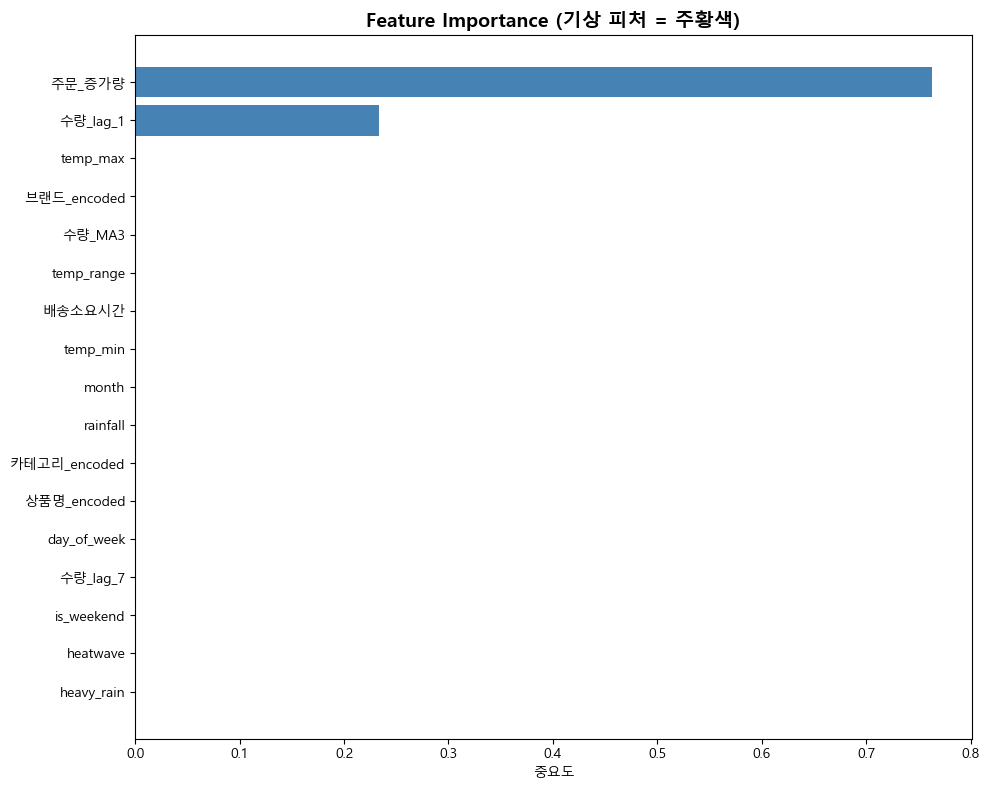


📊 기상 피처 중요도:
  temp_max: 0.0008
  temp_min: 0.0003
  rainfall: 0.0002
  temp_range: 0.0003
  heatwave: 0.0000
  heavy_rain: 0.0000


In [ ]:
# 변수 중요도 시각화 (기상 포함 모델)
feature_importance = pd.DataFrame({
    'feature': features_weather,
    'importance': model_weather.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
colors = ['coral' if 'temp' in f or 'rain' in f or 'heat' in f or 'heavy' in f 
          else 'steelblue' for f in feature_importance['feature']]
plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.xlabel('중요도')
plt.title('Feature Importance (기상 피처 = 주황색)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 기상 피처 중요도:")
weather_features = ['temp_max', 'temp_min', 'rainfall', 'temp_range', 'heatwave', 'heavy_rain']
for feat in weather_features:
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"  {feat}: {imp:.4f}")


## 6. 상품별 기상 포함 모델 비교


In [ ]:
# Top 10 상품별 모델 학습 및 비교
results = []

for product in top_10_products:
    product_df = df_encoded[df_encoded['상품명'] == product].copy()
    
    if len(product_df) < 50:
        print(f"⚠️ {product}: 데이터 부족 (n={len(product_df)})")
        continue
    
    # 데이터 준비
    X_base_p = product_df[features_base]
    X_weather_p = product_df[features_weather]
    y_p = product_df['수량']
    
    # 분할
    split = int(len(X_base_p) * 0.8)
    
    # 기상 미포함 모델
    model_b = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
    model_b.fit(X_base_p[:split], y_p[:split])
    pred_b = model_b.predict(X_base_p[split:])
    mae_b = mean_absolute_error(y_p[split:], pred_b)
    r2_b = r2_score(y_p[split:], pred_b)
    acc_b = (1 - mae_b / y_p[split:].mean()) * 100 if y_p[split:].mean() != 0 else 0
    
    # 기상 포함 모델
    model_w = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
    model_w.fit(X_weather_p[:split], y_p[:split])
    pred_w = model_w.predict(X_weather_p[split:])
    mae_w = mean_absolute_error(y_p[split:], pred_w)
    r2_w = r2_score(y_p[split:], pred_w)
    acc_w = (1 - mae_w / y_p[split:].mean()) * 100 if y_p[split:].mean() != 0 else 0
    
    results.append({
        '상품명': product,
        '데이터수': len(product_df),
        'MAE_미포함': round(mae_b, 3),
        'MAE_포함': round(mae_w, 3),
        'MAE_개선': round(mae_b - mae_w, 3),
        'R2_미포함': round(r2_b, 3),
        'R2_포함': round(r2_w, 3),
        '정확도_미포함': round(acc_b, 2),
        '정확도_포함': round(acc_w, 2),
        '정확도_개선': round(acc_w - acc_b, 2)
    })

df_results = pd.DataFrame(results)
print("\n📊 Top 10 상품별 모델 성능 비교:")
display(df_results)



📊 Top 10 상품별 모델 성능 비교:


,상품명,데이터수,MAE_미포함,MAE_포함,MAE_개선,R2_미포함,R2_포함,정확도_미포함,정확도_포함,정확도_개선
0,Pet Treats,189,0.249,0.259,-0.010,0.849,0.834,91.47,91.12,-0.35
1,Toilet Cleaner,163,0.253,0.282,-0.030,0.785,0.765,89.71,88.50,-1.21
2,Lotion,156,0.093,0.114,-0.021,0.975,0.977,95.49,94.48,-1.02
3,Vitamins,146,0.443,0.521,-0.077,0.762,0.720,83.16,80.22,-2.94
4,Dish Soap,150,0.181,0.229,-0.048,0.957,0.952,93.13,91.30,-1.84
5,Baby Wipes,146,0.121,0.126,-0.005,0.970,0.968,94.07,93.81,-0.26
6,Cough Syrup,151,0.118,0.236,-0.118,0.967,0.896,94.44,88.91,-5.53
7,Cat Food,128,0.218,0.289,-0.072,0.888,0.854,91.56,88.78,-2.78
8,Pulses,118,0.250,0.342,-0.093,0.902,0.877,88.70,84.49,-4.21
9,Orange Juice,95,0.356,0.430,-0.073,0.675,0.585,84.62,81.45,-3.17


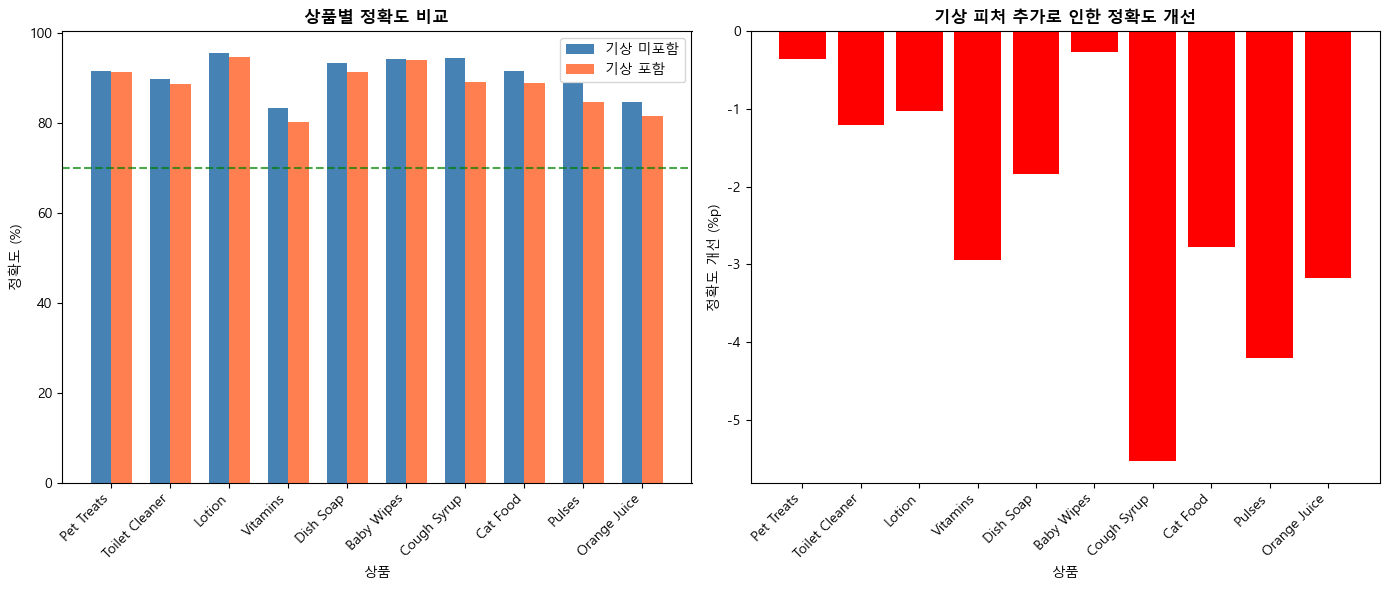

In [ ]:
# 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 정확도 비교
x = np.arange(len(df_results))
width = 0.35

axes[0].bar(x - width/2, df_results['정확도_미포함'], width, label='기상 미포함', color='steelblue')
axes[0].bar(x + width/2, df_results['정확도_포함'], width, label='기상 포함', color='coral')
axes[0].set_xlabel('상품')
axes[0].set_ylabel('정확도 (%)')
axes[0].set_title('상품별 정확도 비교', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_results['상품명'], rotation=45, ha='right')
axes[0].legend()
axes[0].axhline(y=70, color='green', linestyle='--', alpha=0.7, label='목표 70%')

# 개선율
colors = ['green' if v >= 0 else 'red' for v in df_results['정확도_개선']]
axes[1].bar(df_results['상품명'], df_results['정확도_개선'], color=colors)
axes[1].set_xlabel('상품')
axes[1].set_ylabel('정확도 개선 (%p)')
axes[1].set_title('기상 피처 추가로 인한 정확도 개선', fontsize=12, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 7. 결과 저장 및 최종 요약


In [ ]:
# 결과 저장
df_results.to_csv('weather_model_comparison.csv', index=False, encoding='utf-8-sig')
print("✅ weather_model_comparison.csv 저장 완료!")

# 요약 통계
print("\n" + "="*60)
print("📊 기상요인 포함 모델링 최종 요약")
print("="*60)
print(f"\n분석 대상: {len(df_results)}개 상품")
print(f"\n📈 전체 평균 성능:")
print(f"  - 기상 미포함 정확도: {df_results['정확도_미포함'].mean():.2f}%")
print(f"  - 기상 포함 정확도: {df_results['정확도_포함'].mean():.2f}%")
print(f"  - 평균 개선: {df_results['정확도_개선'].mean():+.2f}%p")

improved = len(df_results[df_results['정확도_개선'] > 0])
print(f"\n📌 기상 피처로 개선된 상품: {improved}/{len(df_results)}개 ({improved/len(df_results)*100:.1f}%)")

print(f"\n🏆 가장 큰 개선:")
best = df_results.loc[df_results['정확도_개선'].idxmax()]
print(f"  - {best['상품명']}: {best['정확도_개선']:+.2f}%p 개선")

print(f"\n⚠️ 가장 낮은 개선:")
worst = df_results.loc[df_results['정확도_개선'].idxmin()]
print(f"  - {worst['상품명']}: {worst['정확도_개선']:+.2f}%p")


✅ weather_model_comparison.csv 저장 완료!

📊 기상요인 포함 모델링 최종 요약

분석 대상: 10개 상품

📈 전체 평균 성능:
  - 기상 미포함 정확도: 90.64%
  - 기상 포함 정확도: 88.31%
  - 평균 개선: -2.33%p

📌 기상 피처로 개선된 상품: 0/10개 (0.0%)

🏆 가장 큰 개선:
  - Baby Wipes: -0.26%p 개선

⚠️ 가장 낮은 개선:
  - Cough Syrup: -5.53%p


In [ ]:
# 최종 결과 테이블
print("\n📋 최종 성능 테이블:")
display(df_results.sort_values('정확도_포함', ascending=False))



📋 최종 성능 테이블:


,상품명,데이터수,MAE_미포함,MAE_포함,MAE_개선,R2_미포함,R2_포함,정확도_미포함,정확도_포함,정확도_개선
2,Lotion,156,0.093,0.114,-0.021,0.975,0.977,95.49,94.48,-1.02
5,Baby Wipes,146,0.121,0.126,-0.005,0.970,0.968,94.07,93.81,-0.26
4,Dish Soap,150,0.181,0.229,-0.048,0.957,0.952,93.13,91.30,-1.84
0,Pet Treats,189,0.249,0.259,-0.010,0.849,0.834,91.47,91.12,-0.35
6,Cough Syrup,151,0.118,0.236,-0.118,0.967,0.896,94.44,88.91,-5.53
7,Cat Food,128,0.218,0.289,-0.072,0.888,0.854,91.56,88.78,-2.78
1,Toilet Cleaner,163,0.253,0.282,-0.030,0.785,0.765,89.71,88.50,-1.21
8,Pulses,118,0.250,0.342,-0.093,0.902,0.877,88.70,84.49,-4.21
9,Orange Juice,95,0.356,0.430,-0.073,0.675,0.585,84.62,81.45,-3.17
3,Vitamins,146,0.443,0.521,-0.077,0.762,0.720,83.16,80.22,-2.94


In [ ]:
# 기상 데이터 파일을 프로젝트 폴더로 복사
import shutil

# 파일 복사
src_daily = r'C:\Users\kchne\Downloads\blinkit_with_weather.csv'
src_weekly = r'C:\Users\kchne\Downloads\blinkit_weekly_product_weather.csv'
dst_daily = 'data/blinkit_with_weather.csv'
dst_weekly = 'data/blinkit_weekly_product_weather.csv'

try:
    shutil.copy(src_daily, dst_daily)
    shutil.copy(src_weekly, dst_weekly)
    print("✅ 기상 데이터 파일이 data/ 폴더로 복사되었습니다!")
    print(f"  - {dst_daily}")
    print(f"  - {dst_weekly}")
except Exception as e:
    print(f"⚠️ 파일 복사 실패: {e}")


✅ 기상 데이터 파일이 data/ 폴더로 복사되었습니다!
  - data/blinkit_with_weather.csv
  - data/blinkit_weekly_product_weather.csv
